In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import librosa

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten, LSTM, Activation, Dropout, Dense

Using TensorFlow backend.


## IMPORT DATA

In [2]:
df_tess = pd.read_csv('data/tess.csv')
df_radvess = pd.read_csv('data/radvess.csv')
df_savee = pd.read_csv('data/savee.csv')

In [3]:
df_tess['gender'] = 'female'
df_savee['gender'] = 'male'

In [4]:
def gender(x):
    if int(x[35:-4]) % 2 == 0:
        return 'female'
    else:
        return 'male'
df_radvess['gender'] = df_radvess['filename'].apply(lambda x: gender(x))

In [5]:
from src.clean_data import clean_radvess, clean_tess, clean_savee

df_tess = clean_tess(df_tess)
df_radvess = clean_radvess(df_radvess)
df_savee = clean_savee(df_savee)

In [6]:
df = pd.concat([df_tess, df_radvess, df_savee], axis=0)

In [7]:
def uniform_emotion(x):
    emotion_dict = {'fear' : 'fearful', 'ps' : 'surprised', 'calm' : 'neutral'}
    if x in emotion_dict:
        return emotion_dict[x]
    else: return x

df['emotion'] = df['emotion'].apply(lambda x: uniform_emotion(x))
df = df[df['emotion'].notnull()]

In [8]:
df = df[df['emotion'] != 'disgust']

In [9]:
df['emotion'] = df['gender'] + '_' + df['emotion']
df = df.drop(columns='gender')

In [10]:
df['emotion'].unique()

array(['female_neutral', 'female_fearful', 'female_angry', 'female_happy',
       'female_sad', 'female_surprised', 'male_sad', 'male_neutral',
       'male_angry', 'male_happy', 'male_surprised', 'male_fearful'],
      dtype=object)

## CREATE X AND Y

In [11]:
emotion = df['emotion']
encoder = LabelEncoder()
y = encoder.fit_transform(emotion)

In [12]:
# df.groupby(emotion).count()

In [13]:
encoder.inverse_transform(np.unique(y))

array(['female_angry', 'female_fearful', 'female_happy', 'female_neutral',
       'female_sad', 'female_surprised', 'male_angry', 'male_fearful',
       'male_happy', 'male_neutral', 'male_sad', 'male_surprised'],
      dtype=object)

In [14]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [15]:
scaler = StandardScaler()
X = scaler.fit(np.array(df.iloc[:, :-1], dtype = float))
X = scaler.transform(np.array(df.iloc[:, :-1], dtype = float))
X = X.reshape(X.shape[0], X.shape[1],1)

In [16]:
X.shape

(4061, 25, 1)

## TRAIN_TEST_SPLIT

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [18]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [19]:
y_train.shape

(3248, 12)

## MODEL

In [20]:
model = keras.Sequential()

model.add(Conv1D(16, 5,padding='same',
                 input_shape=(25,1)))
model.add(Activation('relu'))
model.add(Conv1D(32, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(8)))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
## unstacking rows of pixels in the image and lining them up
model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
## The second (and last) layer is a 10-node softmax layer that 
##    returns an array of 10 probability scores that sum to 1
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 16)            96        
_________________________________________________________________
activation_1 (Activation)    (None, 25, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 32)            2592      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 64)            10304     
_________________________________________________________________
activation_3 (Activation)    (None, 25, 64)           

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=16, epochs=24, validation_data=(X_test, y_test))

Train on 3248 samples, validate on 813 samples
Epoch 1/24
3248/3248 [==============================] - 3s 823us/step - loss: 1.8175 - accuracy: 0.3919 - val_loss: 1.2545 - val_accuracy: 0.5486
Epoch 2/24
3248/3248 [==============================] - 2s 616us/step - loss: 1.0686 - accuracy: 0.6367 - val_loss: 0.9184 - val_accuracy: 0.6888
Epoch 3/24
3248/3248 [==============================] - 2s 636us/step - loss: 0.8195 - accuracy: 0.7121 - val_loss: 0.7902 - val_accuracy: 0.7048
Epoch 4/24
3248/3248 [==============================] - 3s 777us/step - loss: 0.6848 - accuracy: 0.7472 - val_loss: 0.6781 - val_accuracy: 0.7392
Epoch 5/24
3248/3248 [==============================] - 3s 822us/step - loss: 0.5936 - accuracy: 0.7848 - val_loss: 0.5744 - val_accuracy: 0.7860
Epoch 6/24
3248/3248 [==============================] - 2s 702us/step - loss: 0.5493 - accuracy: 0.8011 - val_loss: 0.5411 - val_accuracy: 0.7983
Epoch 7/24
3248/3248 [==============================] - 2s 562us/step - loss:

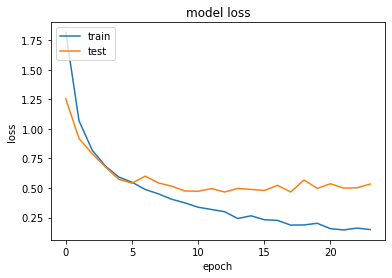

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 84.62%


## PREDICTIONS

In [25]:
preds = model.predict(X_test, 
                         batch_size=32, 
                         verbose=1)

preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (encoder.inverse_transform((abc)))

813/813 [==============================] - 0s 339us/step


In [26]:
preddf = pd.DataFrame({'predictedvalues': predictions})
actual=y_test.argmax(axis=1).astype(int).flatten()
actualvalues = (encoder.inverse_transform((actual)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)
finaldf.head()

,actualvalues,predictedvalues
0,female_angry,female_angry
1,female_sad,female_sad
2,female_neutral,female_neutral
3,female_happy,female_happy
4,female_neutral,female_sad


In [27]:
finaldf['Correct'] = np.where(finaldf['predictedvalues'] == finaldf['actualvalues'], True, False)

In [28]:
finaldf[finaldf['Correct'] == False].groupby('actualvalues').count()

,predictedvalues,Correct
actualvalues,,
female_angry,3,3
female_fearful,12,12
female_happy,13,13
female_neutral,3,3
female_sad,14,14
female_surprised,11,11
male_angry,9,9
male_fearful,15,15
male_happy,9,9


In [29]:
finaldf[finaldf['Correct'] == False].groupby('predictedvalues').count()

,actualvalues,Correct
predictedvalues,,
female_angry,11,11
female_fearful,7,7
female_happy,14,14
female_neutral,14,14
female_sad,4,4
female_surprised,8,8
male_angry,9,9
male_fearful,9,9
male_happy,16,16


In [30]:
incorrect = finaldf[finaldf['Correct'] == False]

In [31]:
incorrect[incorrect['predictedvalues'] == 'male_happy']

,actualvalues,predictedvalues,Correct
137,male_fearful,male_happy,False
176,male_sad,male_happy,False
241,male_surprised,male_happy,False
261,male_angry,male_happy,False
285,male_fearful,male_happy,False
433,male_angry,male_happy,False
476,male_surprised,male_happy,False
509,male_sad,male_happy,False
546,male_angry,male_happy,False
628,male_angry,male_happy,False


In [32]:
finaldf.groupby('predictedvalues').count()

,actualvalues,Correct
predictedvalues,,
female_angry,107,107
female_fearful,94,94
female_happy,101,101
female_neutral,120,120
female_sad,89,89
female_surprised,96,96
male_angry,31,31
male_fearful,25,25
male_happy,38,38


## PICKLE MODEL

In [33]:
# import pickle
# pickle.dump(model, open('pickles/test_model.p','wb'))
# pickle.dump(encoder, open('pickles/test_encoder.p','wb'))
# pickle.dump(scaler, open('pickles/test_scaler.p','wb'))

In [34]:
# pickle_model = pickle.load(open('model.p','rb'))

In [35]:
from src.predict import pred_df_mf
people_dict = {'rob' : 'male', 'jack' : 'male', 'lea' : 'female', 'justin' : 'male'}
model = 'test'
model_predictions = pred_df_mf(model, people_dict)
model_predictions[model_predictions['correct'] == False]

1/1 [==============================] - 0s 58ms/step
Accuracy = 45.45%


,name,actual,predicted,gender,correct
0,lea,female_neutral,male_neutral,female,False
5,justin,male_sad,female_angry,male,False
6,rob,male_happy,female_sad,male,False
7,lea,female_neutral,female_sad,female,False
8,rob,male_angry,female_surprised,male,False
10,justin,male_happy,male_angry,male,False
